In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer13-cleaned-dataset/fear/Training_83381301.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_16420536.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_60662427.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_55547895.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_40980954.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_94300282.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_41634150.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_63945952.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_87504741.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_88977052.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_86791179.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_83159157.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_41203026.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_58373073.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_24628820.jpg
/kaggle/input/fer13-cleaned-dataset/fear/Training_71782

In [2]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [3]:
# Reading input path
INPUT_PATH = "../input/fer13-cleaned-dataset/"

In [4]:
# count of emotions.
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

fear has 2535 number of images
Angry has 2832 number of images
Neutral has 4295 number of images
disgust has 380 number of images
Happy has 6834 number of images

total images are 16876


The above values shows that 'Happy' images count is majority and 'Disgust' images count is in minority. So i would like to drop minority count images from data.

In [5]:
# Removing disgust emotion
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

In [6]:
#Loading images into an array
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all fear images to numpy arrays
loaded all Angry images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all Happy images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [7]:
# Labels are converted to textual format
label_to_text

{0: 'fear', 1: 'Angry', 2: 'Neutral', 3: 'Happy'}

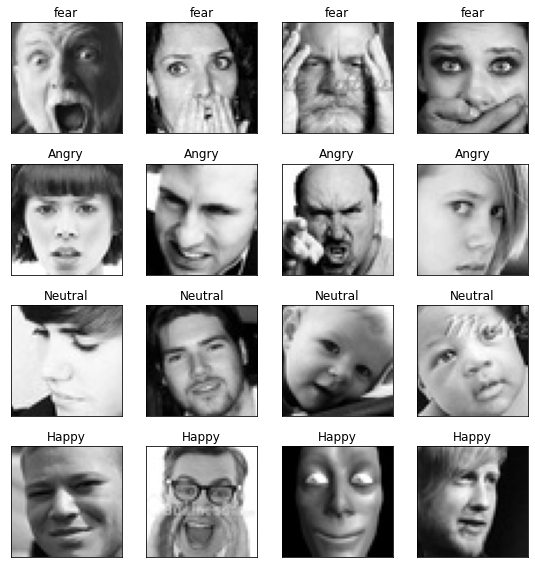

In [8]:
#Plot of emotions
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [9]:
#Converting class vector to binary class matrix
img_label = np_utils.to_categorical(img_label)
img_label.shape

(16496, 4)

In [10]:
#Normalizing the data
img_arr = img_arr / 255.

In [11]:
# Splitting Data into test and train
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 48, 48, 3), (1650, 48, 48, 3), (14846, 4), (1650, 4))

In [12]:
#Deleting the array of images
del img_arr
del img_label

In [13]:
# Defining width, height, depth, and number of classes
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [14]:
#Defining transfer learning model
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)


2021-11-12 05:35:01.128289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 05:35:01.243714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 05:35:01.244461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 05:35:01.245633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

17235968/17225924 [==============================] - 0s 0us/step


In [15]:
#Summary of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 24, 24, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 24, 24, 32)        0     

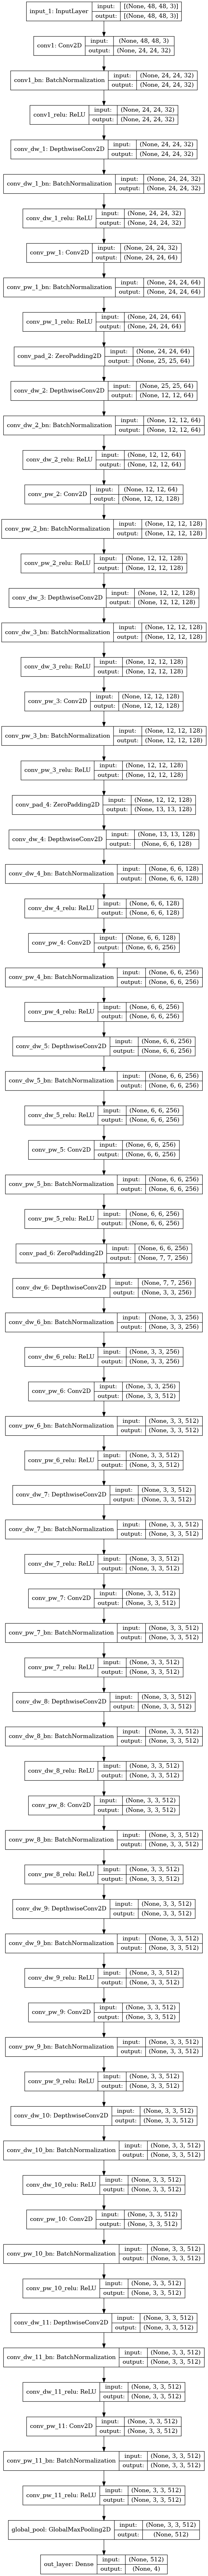

In [16]:
#Visualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, expand_nested=True, to_file='model.png')

In [17]:
for layer in model.layers[:15]:
    layer.trainable = False

In [18]:
#Augumenting Training images
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [19]:
from keras.models import model_from_json

In [20]:
"""
Using two callbacks one is `early stopping` for avoiding overfitting of training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    early_stopping,
    lr_scheduler]

In [21]:
#Fitting the model
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-12 05:35:07.212495: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2021-11-12 05:35:10.521842: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


593/593 [==============================] - 26s 30ms/step - loss: 1.4688 - accuracy: 0.4450 - val_loss: 1.3670 - val_accuracy: 0.3424
Epoch 2/40
593/593 [==============================] - 18s 30ms/step - loss: 1.1102 - accuracy: 0.5431 - val_loss: 1.1633 - val_accuracy: 0.5127
Epoch 3/40
593/593 [==============================] - 17s 29ms/step - loss: 0.9874 - accuracy: 0.5952 - val_loss: 0.8879 - val_accuracy: 0.6570
Epoch 4/40
593/593 [==============================] - 18s 30ms/step - loss: 0.9260 - accuracy: 0.6272 - val_loss: 0.9437 - val_accuracy: 0.6303
Epoch 5/40
593/593 [==============================] - 18s 29ms/step - loss: 0.8851 - accuracy: 0.6439 - val_loss: 0.8564 - val_accuracy: 0.6648
Epoch 6/40
593/593 [==============================] - 18s 30ms/step - loss: 0.8623 - accuracy: 0.6574 - val_loss: 0.8550 - val_accuracy: 0.6630
Epoch 7/40
593/593 [==============================] - 19s 32ms/step - loss: 0.8416 - accuracy: 0.6646 - val_loss: 0.8232 - val_accuracy: 0.6842
Epo

In [22]:
model.save('/kaggle/working/transfer_learning.h5')

In [23]:
#Fetching accuracy and loss of test and train dataset
score = model.evaluate(X_test, y_test,verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])
test_image = X_test[0:1]
print (test_image.shape)

score = model.evaluate(X_train, y_train,verbose=0) 
print('Train Loss:', score[0])
print('Train accuracy:', score[1])
train_image = X_train[0:1]
print (test_image.shape)

Test Loss: 0.6267307996749878
Test accuracy: 0.7509090900421143
(1, 48, 48, 3)
Train Loss: 0.5381519794464111
Train accuracy: 0.7915936708450317
(1, 48, 48, 3)


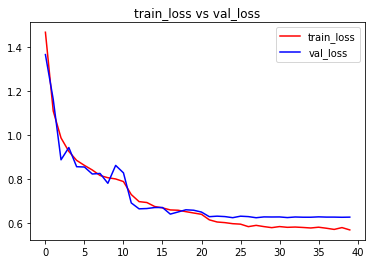

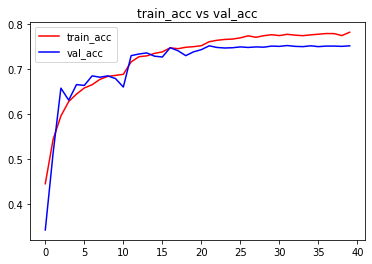

<Figure size 432x288 with 0 Axes>

In [24]:
#Visualization of model performance
import matplotlib.pyplot as plt
train_loss= history.history['loss']
val_loss= history.history['val_loss']
train_acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()
plt.savefig('model_epoch_history.png')


In [25]:

# Fetching label to text 
label_to_text


{0: 'fear', 1: 'Angry', 2: 'Neutral', 3: 'Happy'}

In [26]:
#Converting label_to_text to text_to_label
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'fear': 0, 'Angry': 1, 'Neutral': 2, 'Happy': 3}

test accuracy: 75.0909 %


              precision    recall  f1-score   support

           0       0.69      0.54      0.61       253
           1       0.61      0.63      0.62       283
           2       0.64      0.76      0.70       430
           3       0.91      0.87      0.89       684

    accuracy                           0.75      1650
   macro avg       0.72      0.70      0.70      1650
weighted avg       0.76      0.75      0.75      1650



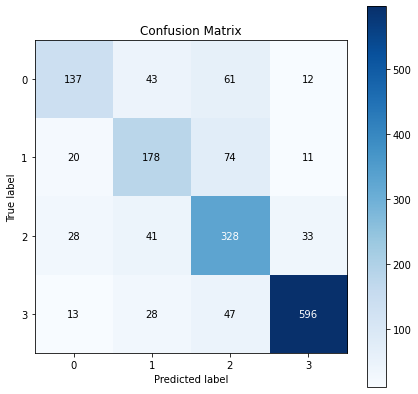

In [27]:
# Classification Report and confusion matrix
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("model_confusion_matrix.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

The confusion matrix clearly shows that model is doing good job on the class happy but it's performance is not that good on other classes. One of the reason for this could be the fact that these classes have less data as compared to happy.

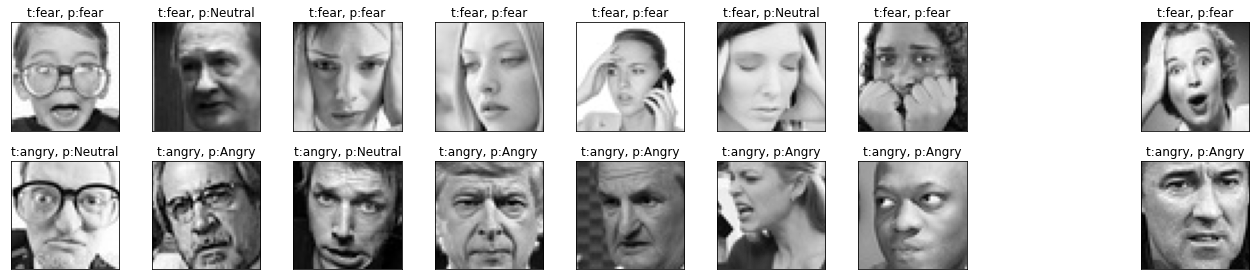

In [28]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]
        
        
        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

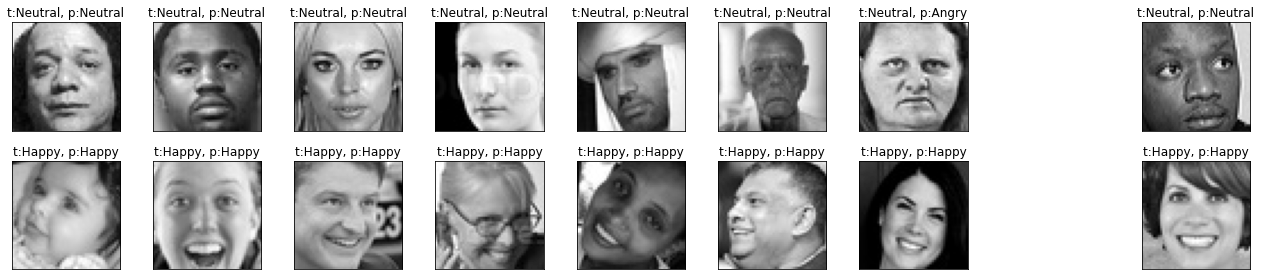

In [29]:
np.random.seed(42)
neutral_imgs = np.random.choice(np.where(y_test[:, text_to_label["Neutral"]]==1)[0], size=9, replace=False)
happy_imgs = np.random.choice(np.where(y_test[:, text_to_label["Happy"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(neutral_imgs, happy_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:Neutral, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]
        
        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:Happy, p:{pred}")

        pyplot.tight_layout()

The reason for low accuracy is the data quality. there are miss-classified images in the dataset. Many of them doesn't belong to their true class but are actually looking more likely to the predicted class.